# Session 22: TensorFlow (workshop)
### Presented by [Jeff Heaton, RGA](https://sites.wustl.edu/jeffheaton/)
For more examples like these, refer to my [class website](https://sites.wustl.edu/jeffheaton/t81-558/)

In [1]:
# What version of Python do you have?

import sys
print (sys.version)

3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
# Do you have TensorFlow installed?

import tensorflow

print(tensorflow.__version__)

1.2.1


# TensorFlow as a Computation Engine

In [3]:
# Very simple calculation.

import tensorflow as tf 

matrix1 = tf.constant([[3., 3.]]) 
matrix2 = tf.constant([[2.],[2.]]) 
product = tf.matmul(matrix1, matrix2) 

with tf.Session() as sess: 
    result = sess.run([product]) 

print(result)

[array([[ 12.]], dtype=float32)]


In [4]:
# With variables.

import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])
x.initializer.run()

sub = tf.subtract(x, a)
print(sub.eval())

sess.run(x.assign([4.0, 6.0])) 
print(sub.eval())


[-2. -1.]
[ 1.  3.]


# Mandelbrot in TensorFlow

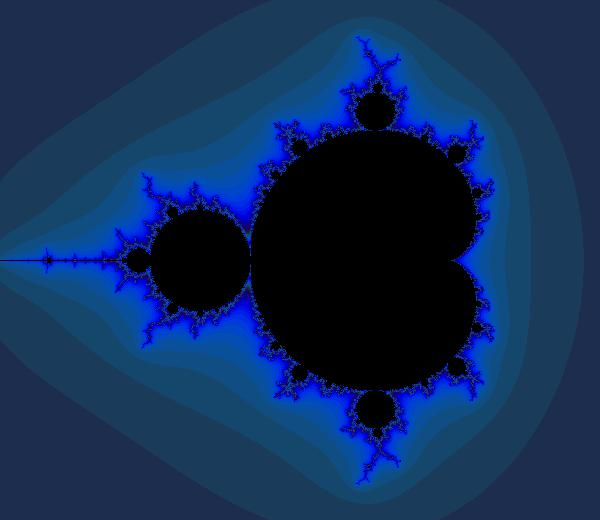

In [5]:
# Import libraries for simulation
import tensorflow as tf
import numpy as np

# Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import Image, display

def DisplayFractal(a, fmt='jpeg'):
  """Display an array of iteration counts as a
     colorful picture of a fractal."""
  a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

sess = tf.InteractiveSession()

# Use NumPy to create a 2D array of complex numbers

Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
Z = X+1j*Y

xs = tf.constant(Z.astype(np.complex64))
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.float32))

tf.global_variables_initializer().run()

# Compute the new values of z: z^2 + x
zs_ = zs*zs + xs

# Have we diverged with this new value?
not_diverged = tf.abs(zs_) < 4

step = tf.group(
  zs.assign(zs_),
  ns.assign_add(tf.cast(not_diverged, tf.float32))
  )

for i in range(200): step.run()
    
DisplayFractal(ns.eval())

# Helpful Functions for Keras and TensorFlow

In [6]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Classification

In [7]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Using TensorFlow backend.


Train on 150 samples, validate on 38 samples
Epoch 1/1000
0s - loss: 1.0984 - val_loss: 1.0987
Epoch 2/1000
0s - loss: 1.0927 - val_loss: 1.0937
Epoch 3/1000
0s - loss: 1.0881 - val_loss: 1.0907
Epoch 4/1000
0s - loss: 1.0851 - val_loss: 1.0880
Epoch 5/1000
0s - loss: 1.0820 - val_loss: 1.0852
Epoch 6/1000
0s - loss: 1.0789 - val_loss: 1.0824
Epoch 7/1000
0s - loss: 1.0751 - val_loss: 1.0789
Epoch 8/1000
0s - loss: 1.0711 - val_loss: 1.0748
Epoch 9/1000
0s - loss: 1.0666 - val_loss: 1.0701
Epoch 10/1000
0s - loss: 1.0619 - val_loss: 1.0655
Epoch 11/1000
0s - loss: 1.0563 - val_loss: 1.0598
Epoch 12/1000
0s - loss: 1.0504 - val_loss: 1.0533
Epoch 13/1000
0s - loss: 1.0440 - val_loss: 1.0464
Epoch 14/1000
0s - loss: 1.0369 - val_loss: 1.0386
Epoch 15/1000
0s - loss: 1.0294 - val_loss: 1.0297
Epoch 16/1000
0s - loss: 1.0209 - val_loss: 1.0206
Epoch 17/1000
0s - loss: 1.0121 - val_loss: 1.0103
Epoch 18/1000
0s - loss: 1.0024 - val_loss: 0.9990
Epoch 19/1000
0s - loss: 0.9918 - val_loss: 0.

0s - loss: 0.3393 - val_loss: 0.2982
Epoch 167/1000
0s - loss: 0.3384 - val_loss: 0.2971
Epoch 168/1000
0s - loss: 0.3369 - val_loss: 0.2958
Epoch 169/1000
0s - loss: 0.3356 - val_loss: 0.2947
Epoch 170/1000
0s - loss: 0.3349 - val_loss: 0.2935
Epoch 171/1000
0s - loss: 0.3334 - val_loss: 0.2924
Epoch 172/1000
0s - loss: 0.3319 - val_loss: 0.2914
Epoch 173/1000
0s - loss: 0.3308 - val_loss: 0.2903
Epoch 174/1000
0s - loss: 0.3297 - val_loss: 0.2892
Epoch 175/1000
0s - loss: 0.3286 - val_loss: 0.2883
Epoch 176/1000
0s - loss: 0.3276 - val_loss: 0.2869
Epoch 177/1000
0s - loss: 0.3260 - val_loss: 0.2858
Epoch 178/1000
0s - loss: 0.3252 - val_loss: 0.2845
Epoch 179/1000
0s - loss: 0.3235 - val_loss: 0.2834
Epoch 180/1000
0s - loss: 0.3224 - val_loss: 0.2823
Epoch 181/1000
0s - loss: 0.3213 - val_loss: 0.2812
Epoch 182/1000
0s - loss: 0.3202 - val_loss: 0.2800
Epoch 183/1000
0s - loss: 0.3188 - val_loss: 0.2789
Epoch 184/1000
0s - loss: 0.3175 - val_loss: 0.2779
Epoch 185/1000
0s - loss: 0

0s - loss: 0.1903 - val_loss: 0.1586
Epoch 329/1000
0s - loss: 0.1898 - val_loss: 0.1578
Epoch 330/1000
0s - loss: 0.1891 - val_loss: 0.1573
Epoch 331/1000
0s - loss: 0.1885 - val_loss: 0.1568
Epoch 332/1000
0s - loss: 0.1879 - val_loss: 0.1563
Epoch 333/1000
0s - loss: 0.1874 - val_loss: 0.1561
Epoch 334/1000
0s - loss: 0.1874 - val_loss: 0.1560
Epoch 335/1000
0s - loss: 0.1869 - val_loss: 0.1546
Epoch 336/1000
0s - loss: 0.1860 - val_loss: 0.1542
Epoch 337/1000
0s - loss: 0.1852 - val_loss: 0.1534
Epoch 338/1000
0s - loss: 0.1846 - val_loss: 0.1530
Epoch 339/1000
0s - loss: 0.1840 - val_loss: 0.1526
Epoch 340/1000
0s - loss: 0.1836 - val_loss: 0.1520
Epoch 341/1000
0s - loss: 0.1828 - val_loss: 0.1519
Epoch 342/1000
0s - loss: 0.1823 - val_loss: 0.1514
Epoch 343/1000
0s - loss: 0.1819 - val_loss: 0.1508
Epoch 344/1000
0s - loss: 0.1812 - val_loss: 0.1502
Epoch 345/1000
0s - loss: 0.1814 - val_loss: 0.1493
Epoch 346/1000
0s - loss: 0.1801 - val_loss: 0.1489
Epoch 347/1000
0s - loss: 0

0s - loss: 0.1220 - val_loss: 0.0958
Epoch 496/1000
0s - loss: 0.1217 - val_loss: 0.0956
Epoch 497/1000
0s - loss: 0.1215 - val_loss: 0.0955
Epoch 498/1000
0s - loss: 0.1213 - val_loss: 0.0953
Epoch 499/1000
0s - loss: 0.1218 - val_loss: 0.0948
Epoch 500/1000
0s - loss: 0.1208 - val_loss: 0.0946
Epoch 501/1000
0s - loss: 0.1205 - val_loss: 0.0944
Epoch 502/1000
0s - loss: 0.1199 - val_loss: 0.0942
Epoch 503/1000
0s - loss: 0.1197 - val_loss: 0.0939
Epoch 504/1000
0s - loss: 0.1194 - val_loss: 0.0937
Epoch 505/1000
0s - loss: 0.1192 - val_loss: 0.0935
Epoch 506/1000
0s - loss: 0.1189 - val_loss: 0.0931
Epoch 507/1000
0s - loss: 0.1186 - val_loss: 0.0929
Epoch 508/1000
0s - loss: 0.1185 - val_loss: 0.0926
Epoch 509/1000
0s - loss: 0.1179 - val_loss: 0.0924
Epoch 510/1000
0s - loss: 0.1177 - val_loss: 0.0923
Epoch 511/1000
0s - loss: 0.1175 - val_loss: 0.0921
Epoch 512/1000
0s - loss: 0.1180 - val_loss: 0.0920
Epoch 513/1000
0s - loss: 0.1171 - val_loss: 0.0916
Epoch 514/1000
0s - loss: 0

In [8]:
from sklearn import metrics
import tensorflow as tf

# Evaluate success using accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9736842105263158


# Regression

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 398 samples, validate on 100 samples
Epoch 1/1000
0s - loss: 316.7480 - val_loss: 143.9322
Epoch 2/1000
0s - loss: 170.2959 - val_loss: 146.2024
Epoch 3/1000
0s - loss: 169.1210 - val_loss: 130.4604
Epoch 4/1000
0s - loss: 160.8918 - val_loss: 129.4031
Epoch 5/1000
0s - loss: 158.2303 - val_loss: 125.9698
Epoch 6/1000
0s - loss: 155.5611 - val_loss: 123.6084
Epoch 7/1000
0s - loss: 151.9272 - val_loss: 120.3858
Epoch 8/1000
0s - loss: 149.5229 - val_loss: 117.4196
Epoch 9/1000
0s - loss: 144.9586 - val_loss: 114.4553
Epoch 10/1000
0s - loss: 141.0111 - val_loss: 110.5800
Epoch 11/1000
0s - loss: 137.4179 - val_loss: 106.6368
Epoch 12/1000
0s - loss: 132.3896 - val_loss: 103.1701
Epoch 13/1000
0s - loss: 128.8498 - val_loss: 98.2748
Epoch 14/1000
0s - loss: 122.4264 - val_loss: 93.9718
Epoch 15/1000
0s - loss: 116.0715 - val_loss: 88.6000
Epoch 16/1000
0s - loss: 110.4475 - val_loss: 83.5048
Epoch 17/1000
0s - loss: 104.1281 - val_loss: 78.3910
Epoch 18/1000
0s - loss: 98.5318 

In [10]:
# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (RMSE): {}".format(np.sqrt(score)))

Final score (RMSE): 2.95761775970459


# LSTM

In [11]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import numpy as np

max_features = 4 # 0,1,2,3 (total of 4)
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
x = np.array(x,dtype=np.float32)
y = np.array([1,2,3,2,3,1],dtype=np.int32)

# Convert y2 to dummy variables
y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
y2[np.arange(y.shape[0]), y] = 1.0
print(y2)

print('Build model...')
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_dim=1))
model.add(Dense(4, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x,y2,epochs=200)
pred = model.predict(x)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected classes: {}",predict_classes)

[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  1.  0.  0.]]
Build model...


/Users/jeff/anaconda/envs/wustl/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/jeff/anaconda/envs/wustl/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1))`


Train...
Epoch 1/200
6/6 [==============================] - 1s - loss: 0.7041 - acc: 0.3750
Epoch 2/200
6/6 [==============================] - 0s - loss: 0.6971 - acc: 0.5417
Epoch 3/200
6/6 [==============================] - 0s - loss: 0.6874 - acc: 0.7083
Epoch 4/200
6/6 [==============================] - 0s - loss: 0.6869 - acc: 0.7500
Epoch 5/200
6/6 [==============================] - 0s - loss: 0.6801 - acc: 0.6250
Epoch 6/200
6/6 [==============================] - 0s - loss: 0.6756 - acc: 0.7083
Epoch 7/200
6/6 [==============================] - 0s - loss: 0.6676 - acc: 0.7500
Epoch 8/200
6/6 [==============================] - 0s - loss: 0.6644 - acc: 0.7083
Epoch 9/200
6/6 [==============================] - 0s - loss: 0.6530 - acc: 0.7500
Epoch 10/200
6/6 [==============================] - 0s - loss: 0.6436 - acc: 0.7500
Epoch 11/200
6/6 [==============================] - 0s - loss: 0.6385 - acc: 0.7500
Epoch 12/200
6/6 [==============================] - 0s - loss: 0.6180 - acc:

6/6 [==============================] - 0s - loss: 0.3800 - acc: 0.8333
Epoch 99/200
6/6 [==============================] - 0s - loss: 0.4387 - acc: 0.7917
Epoch 100/200
6/6 [==============================] - 0s - loss: 0.4304 - acc: 0.7917
Epoch 101/200
6/6 [==============================] - 0s - loss: 0.2522 - acc: 0.9167
Epoch 102/200
6/6 [==============================] - 0s - loss: 0.2264 - acc: 0.9167
Epoch 103/200
6/6 [==============================] - 0s - loss: 0.2427 - acc: 0.9167
Epoch 104/200
6/6 [==============================] - 0s - loss: 0.3407 - acc: 0.8750
Epoch 105/200
6/6 [==============================] - 0s - loss: 0.2495 - acc: 0.9167
Epoch 106/200
6/6 [==============================] - 0s - loss: 0.2415 - acc: 0.9167
Epoch 107/200
6/6 [==============================] - 0s - loss: 0.3487 - acc: 0.8750
Epoch 108/200
6/6 [==============================] - 0s - loss: 0.2802 - acc: 0.8750
Epoch 109/200
6/6 [==============================] - 0s - loss: 0.2318 - acc: 0.

6/6 [==============================] - 0s - loss: 0.1183 - acc: 1.0000
Epoch 195/200
6/6 [==============================] - 0s - loss: 0.2428 - acc: 0.9167
Epoch 196/200
6/6 [==============================] - 0s - loss: 0.1045 - acc: 0.9583
Epoch 197/200
6/6 [==============================] - 0s - loss: 0.0911 - acc: 1.0000
Epoch 198/200
6/6 [==============================] - 0s - loss: 0.1424 - acc: 1.0000
Epoch 199/200
6/6 [==============================] - 0s - loss: 0.1818 - acc: 0.9167
Epoch 200/200
6/6 [==============================] - 0s - loss: 0.1514 - acc: 0.9583
Predicted classes: {} [1 2 3 2 3 1]
Expected classes: {} [1 2 3 2 3 1]


In [12]:
def runit(model, inp):
    inp = np.array(inp,dtype=np.float32)
    pred = model.predict(inp)
    return np.argmax(pred[0])

print( runit( model, [[[0],[0],[0],[0],[3],[3]]] ))

3
